In [1]:
# Get Data
from general_functions.file_operations import read_txt_file
data_folder = "../data/"
text_file_location = data_folder + "extracted_chapters/Chapter_1.txt"
text = read_txt_file(text_file_location)
print(text)

1 Papa and Mama




My father, Harald Dahl, was a Norwegian who came from a small town near Oslo, called Sarpsborg. His own father, my grandfather, was a fairly prosperous merchant who owned a store in Sarpsborg and traded in just about everything from cheese to chicken-wire.


I am writing these words in 1984, but this grandfather of mine was born, believe it or not, in 1820, shortly after Wellington had defeated Napoleon at Waterloo. If my grandfather had been alive today he would have been one hundred and sixty-four years old. My father would have been one hundred and twenty-one. Both my father and my grandfather were late starters so far as children were concerned.


When my father was fourteen, which is still more than one hundred years ago, he was up on the roof of the family house replacing some loose tiles when he slipped and fell. He broke his left arm below the elbow. Somebody ran to fetch the doctor, and half an hour later this gentleman made a majestic and drunken arrival i

Run BookNLP pipeline, create 

In [2]:
## BookNLP Stuff
from general_functions.booknlp import run_booknlp

# Constants 
# Input file to process
input_file="../data/dahl-boy-4.txt"
# Output directory to store resulting files in 
output="../data/booknlp_output/boy/"
# File within this directory will be named ${book_id}.entities, ${book_id}.tokens, etc.
id="boy"
pipeline="entity,quote,supersense,event,coref"

#Call functions
run_booknlp(input_file_location=input_file, output_directory=output, book_id=id,pipeline=pipeline)


c:\Users\Raquel Coelho\Desktop\Elalytics_Deepak\elalytics-data-processing\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


using device cpu
The following BookNLP files already exist in the output directory:
../data/booknlp_output/boy\boy.book
../data/booknlp_output/boy\boy.book.html
../data/booknlp_output/boy\boy.entities
../data/booknlp_output/boy\boy.quotes
../data/booknlp_output/boy\boy.supersense
../data/booknlp_output/boy\boy.tokens
{'pipeline': 'entity,quote,supersense,event,coref', 'model': 'big'}
LUCY'S VERSION
--- startup: 6.421 seconds ---
--- spacy: 4.667 seconds ---
--- entities: 81.384 seconds ---
--- quotes: 0.050 seconds ---
--- attribution: 2.784 seconds ---
--- name coref: 0.077 seconds ---
--- coref: 78.332 seconds ---
--- TOTAL (excl. startup): 167.607 seconds ---, 42853 words
BookNLP processing complete.


CHAPTER 1 Papa and Mama
Mama Engaged
Me at 8 months
________________
Me and Mama Radyr
Llandaff Cathedral
â€˜What is ratitis, Daddy?â€™ young Thwaites had asked.
________________
CHAPTER 4 The Great Mouse Plot
Thwaites hesitated. They all looked at me.
â€˜Of course I did!â€™ I said.
CHAPTER 5 Mr Coombes
â€˜Thereâ€™s the mouse!â€™ someone else shouted.
Nobody answered me.
Nobody answered him.
â€˜What?â€™ we said. â€˜What happens?â€™
â€˜Shut up,â€™ Mr Coombes said.
â€˜Youâ€™re quite sure?â€™ Mr Coombes said.
â€˜Enter!â€™
â€˜Bend over,â€™ Mr Coombes said.
â€˜Tighter, boy, tighter!â€™ Mr Coombes snapped out. â€˜Touch the ground!â€™
â€˜Ow-w-w-w-w!â€™ yelled Thwaites.
â€˜Next!â€™ snapped Mr Coombes.
â€˜What did you say?â€™
CHAPTER 7Going to Norway
Bestemama and Bestepapa (and Astri)
Me, Alfhild, Else â€“ Norway 1924
â€˜What are they?â€™ I asked her.
The Loony Bin!
CHAPTER  12 The Matron
CHAPTER  13 Homesickness
â€˜Whatâ€™s it for?â€™ I asked her.
â€˜It hurts, Matron,â€™ I moaned. â€˜Oh, it h

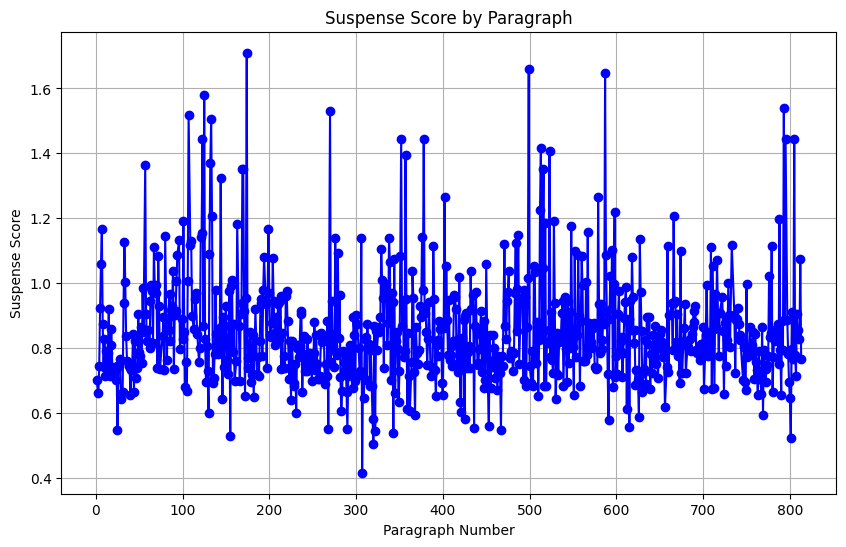

In [18]:
#Suspense chart 
import pandas as pd
import spacy
import json
import matplotlib.pyplot as plt

# Constants
lexicon_path = "C:/Users/Raquel Coelho/Desktop/Elalytics_Deepak/elalytics-data-processing/src/book_projects/dictionaries/NRC-VAD-Lexicon.csv"
story_path = "../data/dahl-boy-4.txt"
output_path = "../data/suspense.json"

# Load the English model for SpaCy
nlp = spacy.load("en_core_web_sm")

def load_lexicon(file_path):
    return pd.read_csv(file_path, sep="\t")

def read_and_split_story(file_path):
    with open(file_path, "r") as file:
        text = file.read()
    return [para.strip() for para in text.split("\n\n") if para]

def get_negative_valence_arousal_score(sentence, lexicon_df):
    doc = nlp(sentence)
    scores = []
    for token in doc:
        word = token.text
        if not word.isalnum():
            continue
        word_data = lexicon_df.loc[lexicon_df['Word'] == word]
        if not word_data.empty:
            valence = word_data['Valence'].values[0]
            arousal = word_data['Arousal'].values[0]
            negative_valence = 1 - valence
            scores.append(negative_valence + arousal)
    if scores:
        return sum(scores) / len(scores)
    else:
        return None

def analyze_paragraphs(paragraphs, lexicon_df):
    para_scores = {}
    for index, para in enumerate(paragraphs):
        sentence_scores = []
        doc = nlp(para)
        max_sent = ""
        max_score = -100
        for sent in doc.sents:
            score = get_negative_valence_arousal_score(sent.text, lexicon_df)
            if score and score > max_score:
                max_score = score
                max_sent = sent.text
            sentence_scores.append(score)
        sentence_scores = [score for score in sentence_scores if score is not None]
        if not sentence_scores:
            print(para)
            continue
        average_score = sum(sentence_scores) / len(sentence_scores)
        para_scores[index + 1] = [average_score, max_sent]
    return para_scores

def write_to_json(data, output_path):
    with open(output_path, "w") as json_file:
        json.dump(data, json_file)

# Load lexicon data
lexicon_df = load_lexicon(lexicon_path)

# Extract paragraphs from the story
paragraphs = read_and_split_story(story_path)

# Analyze the sentiment of paragraphs
results = analyze_paragraphs(paragraphs, lexicon_df)

# Save results to a JSON file
write_to_json(results, output_path)
